# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [300]:
import warnings
warnings.filterwarnings("ignore")

In [301]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [302]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'saved_ressources/')
files

['data_cleaned.csv', 'data_cleaned_wo_tokenizer.csv', 'model.h5']

In [303]:
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned.csv', encoding='utf8')

In [304]:
data = data.applymap(lambda x: ast.literal_eval(x))

In [305]:
data.head()

,Tags,Texts
0,"[macos, emacs, scheme, interpreter, sicp]","[scheme, interpreter, interpreter, python, int..."
1,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,..."
2,"[mysql, database, arrays, postgresql, stored-p...","[pass, array, procedure, pass, array, procedur..."
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, buttonwithtype, figure, button, state,..."
4,"[database, nhibernate, exception-handling, con...","[check, application, column, constraint, colum..."


In [306]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159599 entries, 0 to 159598
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Tags    159599 non-null  object
 1   Texts   159599 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


Le jeu de données est trop important pour les temps de calculs à ma disposition.

J'ai deux possibilités : 
- prendre un sample de 5000 observations aléatoirement
- prendre les 5000 observations pour lesquelles la similarité entre les deux colonnes est importante

In [307]:
# data_sample = data.sample(2000)
# data_sample.reset_index(inplace=True, drop=True)
# print(data_sample.shape)
# data_sample.head()

In [308]:
from typing import List

In [309]:
def jaccard_similarity(list1: List[str], list2: List[str]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

def get_highest_similarity_rows(data: pd.DataFrame, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)


data_sample = get_highest_similarity_rows(data, "Tags", "Texts", 2000)
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(2000, 2)


,Tags,Texts
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da..."
1,"[listview, javafx, tableview, scrollbar, hide]","[hide, scrollbar, listview, javafx, hide, scro..."
2,"[jpa, merge, entitymanager, persist, java-pers...","[jpa, entitymanager, merge, entitymanager, mer..."
3,"[python, django, image, gallery, portfolio]","[create, image, gallery, create, portfolio, dj..."
4,"[python, authentication, proxy, https, ntlm]","[python, https, proxy, ntlm, authentication, s..."


In [310]:
texts_list = data_sample["Texts"].to_list()
tags_list = data_sample["Tags"].to_list()

In [311]:
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]

In [312]:
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

## <font color="#114b98" id="section_2">2. Approche non supervisée</font>

In [313]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, jaccard_score, precision_score
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense
from sklearn.model_selection import train_test_split

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [314]:
def determine_optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test, and the list of texts,
    applies the models to the data and plots the silhouette and coherence scores to help 
    determine the optimal number of topics.
    
    """

    # Vectorize the data
    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    # Initialize lists to store scores for LDA and NMF
    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    # Loop through the range of number of topics
    for n_topics in n_topics_range:
        
        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=1000)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=1000)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())
            
        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())
     
    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'], 
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plt.suptitle('Scores de Silhouette et de Coherence pour LDA et NMF avec {}'.format(str(vectorizer).split('(')[0]))
    
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()

    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()

    plt.show()
    
    return scores

In [315]:
# Define the range of number of topics to test
n_topics_range = range(2, 24, 3)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [316]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

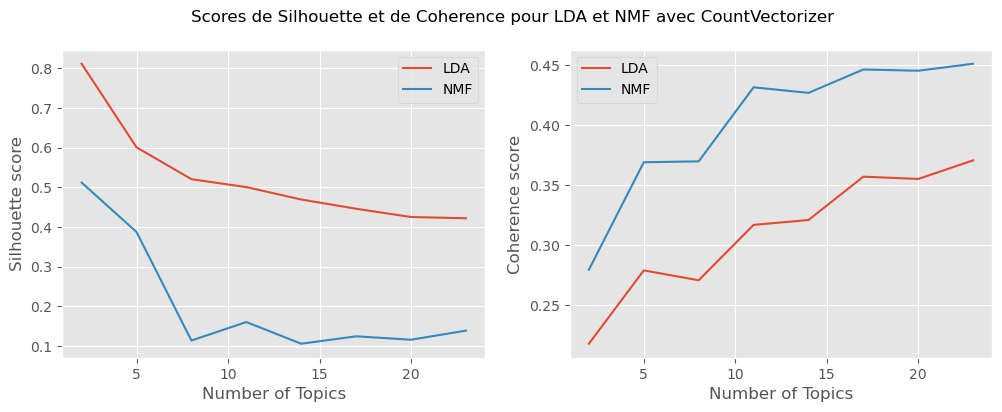

In [317]:
nmf_and_lda_models_with_CountVectorizer = determine_optimal_num_topics(flat_texts,
                                                                       vectorizer,
                                                                       n_topics_range,
                                                                       texts_list)

In [318]:
nmf_and_lda_models_with_CountVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,2,0.811655,23,0.370547
NMF,2,0.511840,23,0.451033


TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [319]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

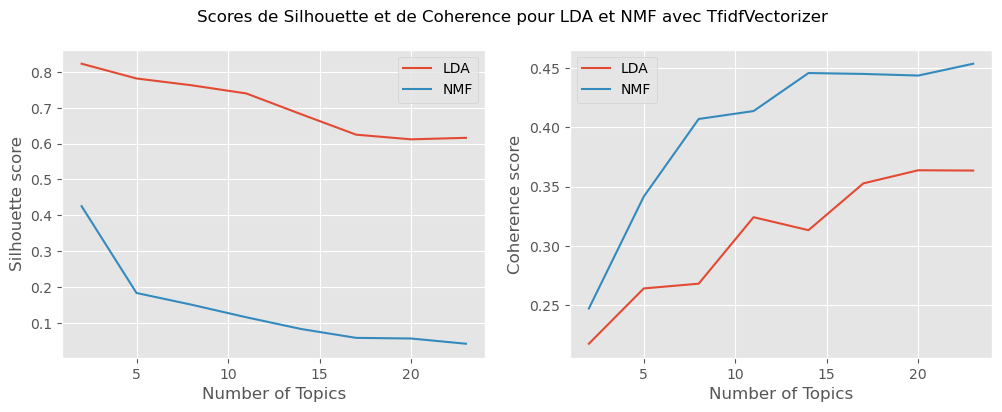

In [320]:
nmf_and_lda_models_with_TfidfVectorizer= determine_optimal_num_topics(flat_texts,
                                                                      vectorizer,
                                                                      n_topics_range,
                                                                      texts_list)

In [321]:
nmf_and_lda_models_with_TfidfVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,2,0.822720,20,0.363772
NMF,2,0.425437,23,0.453700


Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils davantage "interprétables par les humains".

Nous devons maintenant essayer d'obtenir des tags en utilisant ces méthodes.

Je choisis d'utiliser uniquement LDA pour la suite car c'est la méthode qui obtient les meilleurs scores de silhouette.

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [23]:
min_df=50

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [24]:
max_df=0.5

Je choisis le nombre de topics au regard des résultats précédents.

In [25]:
n_topics = 11

In [26]:
def get_tags_from_text(texts_list, flat_texts, n_topics, vocabulary_texts, min_df, max_df):
    pred_tags_gensim = list()
    pred_tags_sklearn = list()
    pred_tags_tfidf = list()
    pred_tags_count = list()
    
    # Predict tags using LdaModel (gensim) without bow or TF-IDF 
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        topics = lda.get_document_topics(bow, minimum_probability=0)
        topic_id, prob = max(topics, key=lambda x: x[1])
        topic_words = [w for w, p in lda.show_topic(topic_id, topn=5)]
        pred_tags_gensim.append(topic_words)

    # Predict tags using LDA (sklearn) without bow or TF-IDF    
    corpus_dense = corpus2dense(corpus, num_terms=len(dictionary)).T
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(corpus_dense)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        dense_bow = corpus2dense([bow], num_terms=len(dictionary)).T[0]
        dense_bow = np.reshape(dense_bow, (1, -1))
        topic_distribution = lda.transform(dense_bow)
        topic_id = topic_distribution.argmax()
        top_words_indices = np.argsort(-lda.components_[topic_id])[:5]
        topic_words = [dictionary[i] for i in top_words_indices]
        pred_tags_sklearn.append(topic_words)     
               
    # Predict tags using LdaModel with TF-IDF 
    vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in range(len(texts_list)):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tags_tfidf.append(topic_words)
        
    # Predict tags using LdaModel with CountVectorizer 
    vectorizer = CountVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in range(len(texts_list)):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tags_count.append(topic_words)           
        
    return pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count

In [27]:
pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count = get_tags_from_text(texts_list,
                                                                                           flat_texts,
                                                                                           n_topics,
                                                                                           vocabulary_texts,
                                                                                           min_df,
                                                                                           max_df)

In [28]:
tags_list[0:5]

[['javascript', 'jquery', 'string', 'date', 'object'],
 ['listview', 'javafx', 'tableview', 'scrollbar', 'hide'],
 ['jpa', 'merge', 'entitymanager', 'persist', 'java-persistence-api'],
 ['python', 'django', 'image', 'gallery', 'portfolio'],
 ['python', 'authentication', 'proxy', 'https', 'ntlm']]

In [29]:
pred_tags_gensim[0:5]

[['date', 'size', 'javascript', 'div', 'way'],
 ['python', 'memory', 'path', 'performance', 'post'],
 ['use', 'int', 'difference', 'way', 'value'],
 ['file', 'image', 'class', 'way', 'value'],
 ['use', 'page', 'project', 'eclipse', 'file']]

In [30]:
pred_tags_sklearn[0:5]

[['date', 'size', 'value', 'column', 'class'],
 ['project', 'page', 'eclipse', 'use', 'process'],
 ['use', 'difference', 'docker', 'commit', 'merge'],
 ['file', 'image', 'class', 'way', 'text'],
 ['project', 'page', 'eclipse', 'use', 'process']]

In [31]:
pred_tags_tfidf[0:5]

[['date', 'string', 'convert', 'object', 'jquery'],
 ['scrollbar', 'listview', 'hide', 'javafx', 'zabbix'],
 ['entitymanager', 'merge', 'persist', 'jpa', 'zabbix'],
 ['django', 'create', 'portfolio', 'gallery', 'model'],
 ['authentication', 'ntlm', 'https', 'proxy', 'laurent']]

In [32]:
pred_tags_count[0:5]

[['date', 'string', 'convert', 'javascript', 'object'],
 ['scrollbar', 'listview', 'hide', 'javafx', 'zabbix'],
 ['entitymanager', 'merge', 'jpa', 'persist', 'zabbix'],
 ['django', 'create', 'model', 'gallery', 'python'],
 ['authentication', 'https', 'proxy', 'ntlm', 'support']]

Il semble que CountVectorizer et TfidfVectorizer prédisent des tags assez similaires.

In [33]:
true_tags = tags_list
pred_tags_list = [pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count]
pred_names = ["gensim", "sklearn", "tfidf", "count"]

In [34]:
mlb = MultiLabelBinarizer()
true_tags_bin = mlb.fit_transform(true_tags)
pred_tags_bin_list = [mlb.transform(pred_tags) for pred_tags in pred_tags_list]

In [215]:
def evaluate_predictions(true_tags, pred_tags_bin_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    accuracy_scores = []
    precision_scores = []
    for pred_tags in pred_tags_bin_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))
        accuracy_scores.append(accuracy_score(true_tags, pred_tags))
        precision_scores.append(precision_score(true_tags, pred_tags, average='samples'))
        
    metrics = {"F1": f1_scores, "Jaccard": jaccard_scores, "Accuracy": accuracy_scores, "Precision": precision_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)
    
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set(ylabel=metric)
    plt.show()
    return metrics_df

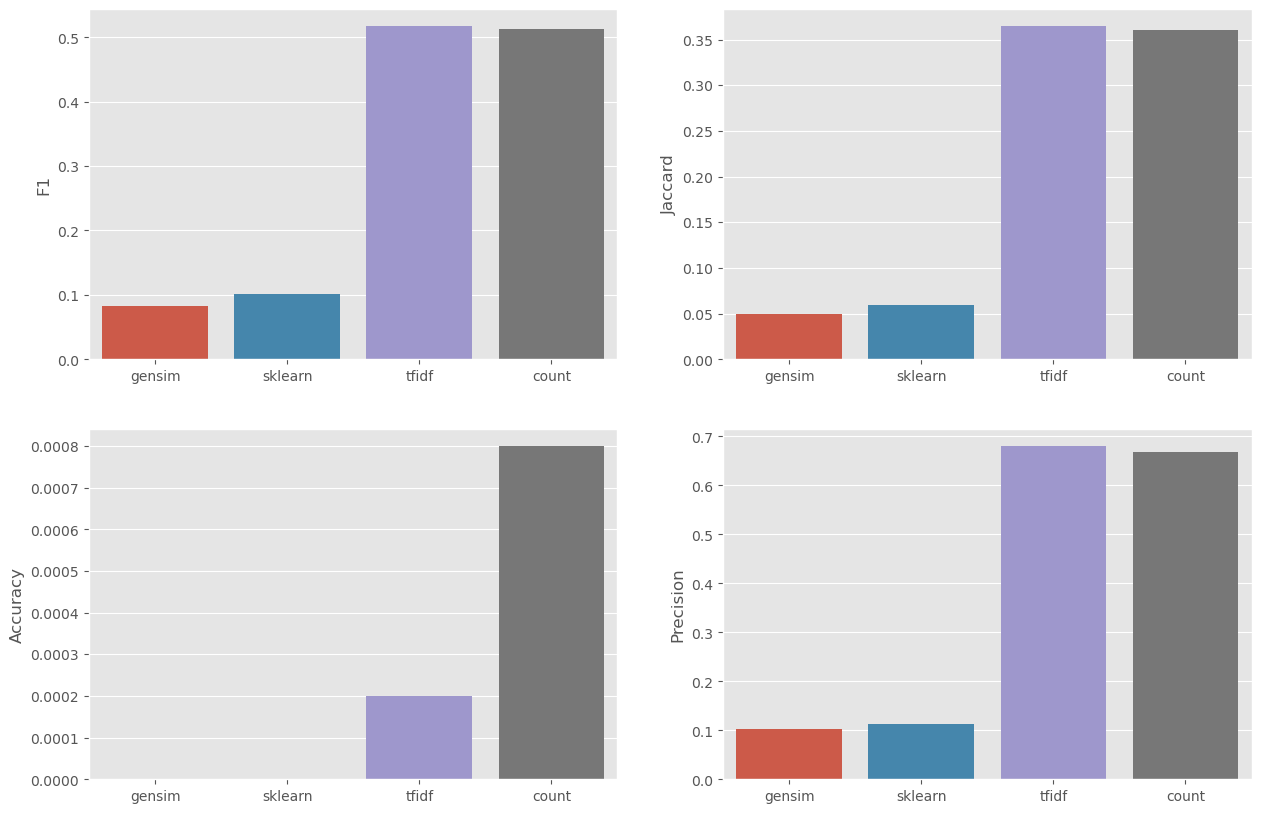

,F1,Jaccard,Accuracy,Precision
gensim,0.083040,0.049039,0.0000,0.103597
sklearn,0.100749,0.059672,0.0000,0.112810
tfidf,0.517630,0.364918,0.0002,0.680527
count,0.513127,0.360835,0.0008,0.668393


In [216]:
evaluate_predictions(true_tags_bin, pred_tags_bin_list, pred_names)

In [217]:
def evaluate_predictions_one_to_one(true_tags, pred_tags_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    accuracy_scores = []
    precision_scores = []
    for pred_tags in pred_tags_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))
        accuracy_scores.append(sum([len(set(true_tags[i]).intersection(pred_tags[i]))/len(true_tags[i]) for i in range(len(true_tags))])/len(true_tags))
        precision_scores.append(precision_score(true_tags, pred_tags, average='samples'))
        
    metrics = {"F1": f1_scores, "Jaccard": jaccard_scores, "Accuracy": accuracy_scores, "Precision": precision_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)
    
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set(ylabel=metric)
    plt.show()
    return metrics_df

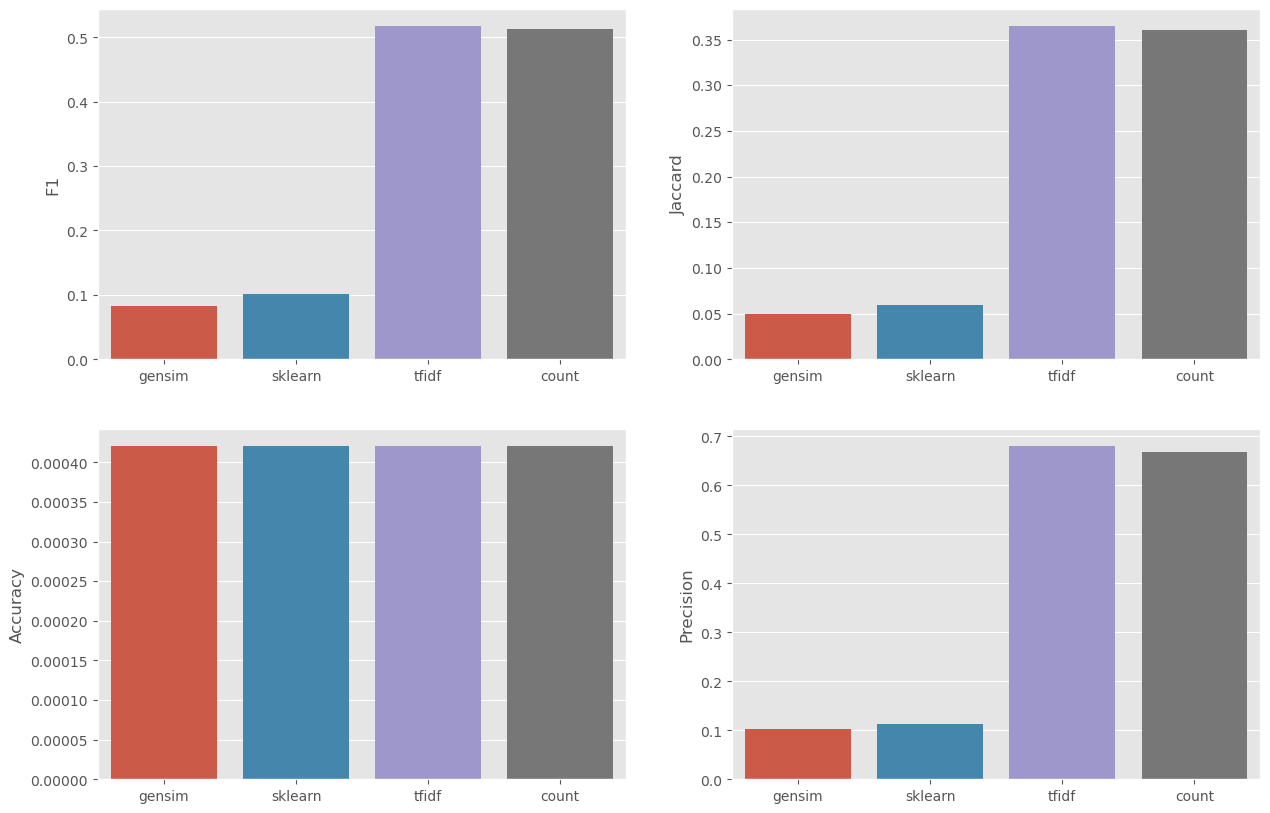

,F1,Jaccard,Accuracy,Precision
gensim,0.083040,0.049039,0.000421,0.103597
sklearn,0.100749,0.059672,0.000421,0.112810
tfidf,0.517630,0.364918,0.000420,0.680527
count,0.513127,0.360835,0.000420,0.668393


In [218]:
evaluate_predictions_one_to_one(true_tags_bin, pred_tags_bin_list, pred_names)

In [323]:
AJOUT PCA !

SyntaxError: invalid syntax (617012100.py, line 1)

## <font color="#114b98" id="section_3">3. Approche supervisée</font>

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [38]:
mlb = MultiLabelBinarizer(classes=vocabulary_tags)

In [39]:
tags_mlb = mlb.fit_transform(flat_tags)

In [40]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               MultinomialNB()]

 - Accuracy: mesure de combien de prédictions faites par le modèle sont correctes
 - Precision: mesure combien des prédictions positives faites par le modèle sont effectivement correctes. Un score de précision élevé signifie que le modèle fait peu de prédictions positives fausses.
 - Recall: mesure combien des exemples positifs réels sont correctement prédits par le modèle. Un score de rappel élevé signifie que le modèle est capable de trouver la plupart des exemples positifs.
 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [41]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers):
    
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall',
                                       'F1 Score', 'Jaccard Score', 'Time (s)'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    
    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in classifiers:
        start_time = time.time()
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        end_time = time.time()
        
        accuracy = round(accuracy_score(y_test, y_pred_ovrc), 4)
        precision = round(precision_score(y_test, y_pred_ovrc, average='samples'), 4)
        recall = round(recall_score(y_test, y_pred_ovrc, average='samples'), 4)
        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        time_taken = round(end_time - start_time, 4)
        
        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                       'Accuracy': accuracy, 
                                       'Precision': precision, 
                                       'Recall': recall, 
                                       'F1 Score': f1, 
                                       'Jaccard Score': jaccard,
                                       'Time (s)': time_taken}, 
                                       ignore_index=True)
                                       
        print('Results for classifier:', classifier)
        print("Accuracy : ", accuracy)
        print("Precision : ", precision)
        print("Recall : ", recall)
        print("F1 Score : ", f1)
        print("Jaccard Score:", jaccard)
        print("Time (s):", time_taken)
        print('\n')
        
    return results_df

In [42]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

In [43]:
results_df_CountVectorizer = calculate_supervised_scores(flat_texts,
                                                         tags_mlb,
                                                         vectorizer,
                                                         classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.624
Precision :  0.8612
Recall :  0.8503
F1 Score :  0.8325
Jaccard Score: 0.7815
Time (s): 1.6395


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.537
Precision :  0.8398
Recall :  0.7905
F1 Score :  0.7879
Jaccard Score: 0.727
Time (s): 1.4984


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.673
Precision :  0.8588
Recall :  0.9362
F1 Score :  0.8769
Jaccard Score: 0.83
Time (s): 9.4704


Results for classifier: KNeighborsClassifier()
Accuracy :  0.585
Precision :  0.8468
Recall :  0.8963
F1 Score :  0.8465
Jaccard Score: 0.7872
Time (s): 1.6341


Results for classifier: MultinomialNB()
Accuracy :  0.611
Precision :  0.842
Recall :  0.8692
F1 Score :  0.8327
Jaccard Score: 0.7808
Time (s): 1.4703




In [44]:
results_df_CountVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s)
0,LogisticRegression,0.624,0.8612,0.8503,0.8325,0.7815,1.6395
1,SGDClassifier,0.537,0.8398,0.7905,0.7879,0.7270,1.4984
2,RandomForestClassifier,0.673,0.8588,0.9362,0.8769,0.8300,9.4704
3,KNeighborsClassifier,0.585,0.8468,0.8963,0.8465,0.7872,1.6341
4,MultinomialNB,0.611,0.8420,0.8692,0.8327,0.7808,1.4703


Selon ces résultats, il semble que le RandomForestClassifier a les meilleures performances globales, avec la plus grande précision, rappel et score F1. Le classificateur de régression logistique se comporte également bien, avec une précision légèrement inférieure.

Cependant, le RandomForestClassifier est aussi le seul à nécessiter un temps d'entraînement aussi long.

In [45]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)
    
    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['Accuracy','Precision','Recall','F1 Score','Jaccard Score', 'Time (s)']
    
    # Create a subplot for each scoring method
    for i, scoring_method in enumerate(scoring_methods):
        sns.barplot(x='Classifier', 
                    y=scoring_method, 
                    data=results_df, 
                    ax=axs[i // 3, i % 3], 
                    palette=my_palette, 
                    label=scoring_method)
    
    # Add classifier names to x-axis
    for i in range(2):
        for j in range(3):
            axs[i,j].set_title(scoring_methods[i*3+j])
            axs[i,j].set_xticks(x)
            axs[i,j].set_xlabel('')
            
            if j == 0:
                axs[i,j].set_ylabel('Score')
            else:
                axs[i,j].set_ylabel('')
            
            if i == 1:
                axs[i,j].set_xticklabels(results_df['Classifier'], rotation=90)
            else:
                axs[i,j].set_xticklabels('')
            
    plt.show()

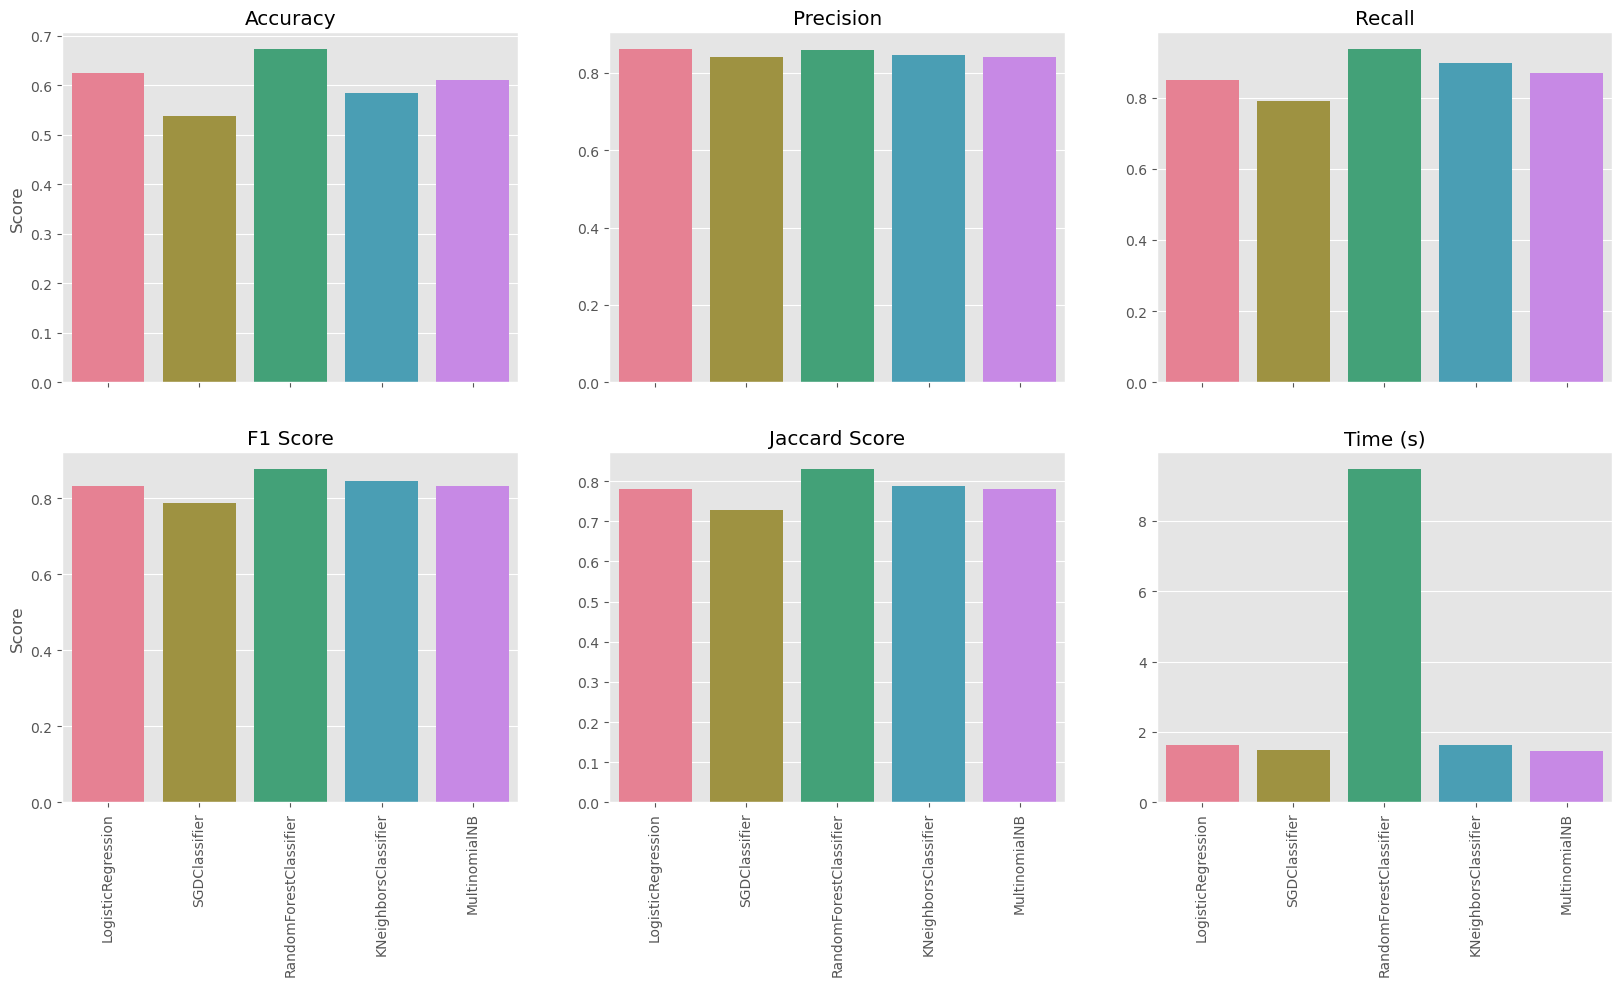

In [46]:
# Call the plot_results function
plot_results(results_df_CountVectorizer)

In [47]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

In [48]:
results_df_TfidfVectorizer = calculate_supervised_scores(flat_texts,
                                                         tags_mlb,
                                                         vectorizer,
                                                         classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.636
Precision :  0.8598
Recall :  0.9048
F1 Score :  0.8616
Jaccard Score: 0.8107
Time (s): 1.5955


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.56
Precision :  0.8538
Recall :  0.7852
F1 Score :  0.7927
Jaccard Score: 0.7357
Time (s): 1.7637


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.672
Precision :  0.8542
Recall :  0.941
F1 Score :  0.8769
Jaccard Score: 0.8298
Time (s): 18.751


Results for classifier: KNeighborsClassifier()
Accuracy :  0.585
Precision :  0.8518
Recall :  0.8732
F1 Score :  0.838
Jaccard Score: 0.7797
Time (s): 1.8467


Results for classifier: MultinomialNB()
Accuracy :  0.591
Precision :  0.8442
Recall :  0.911
F1 Score :  0.8553
Jaccard Score: 0.7965
Time (s): 1.4363




In [49]:
results_df_TfidfVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s)
0,LogisticRegression,0.636,0.8598,0.9048,0.8616,0.8107,1.5955
1,SGDClassifier,0.560,0.8538,0.7852,0.7927,0.7357,1.7637
2,RandomForestClassifier,0.672,0.8542,0.9410,0.8769,0.8298,18.7510
3,KNeighborsClassifier,0.585,0.8518,0.8732,0.8380,0.7797,1.8467
4,MultinomialNB,0.591,0.8442,0.9110,0.8553,0.7965,1.4363


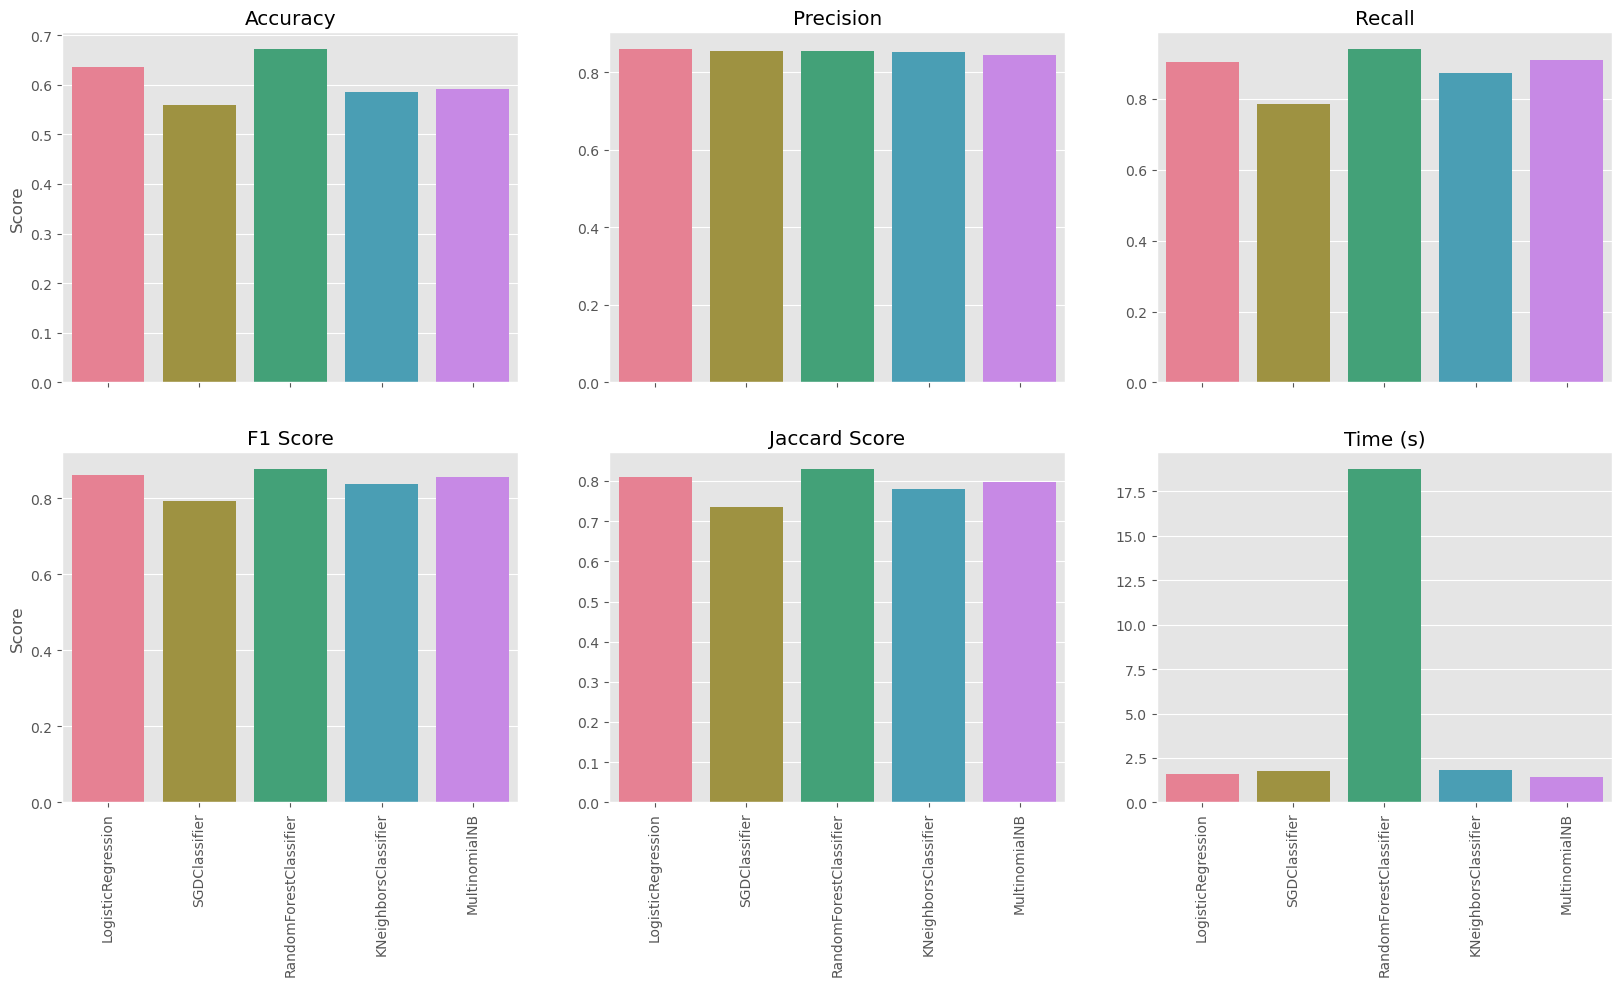

In [50]:
# Call the plot_results function
plot_results(results_df_TfidfVectorizer)

Le RandomForestClassifier obtient les meilleurs scores, peu importe le vectorizer utilisé.

In [51]:
results_RFC = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Jaccard Score'])
results_RFC = results_RFC.append(results_df_CountVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC = results_RFC.append(results_df_TfidfVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_RFC

,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s),Classifier
0,0.673,0.8588,0.9362,0.8769,0.8300,9.4704,CountVectorizer
1,0.672,0.8542,0.9410,0.8769,0.8298,18.7510,TfidfVectorizer


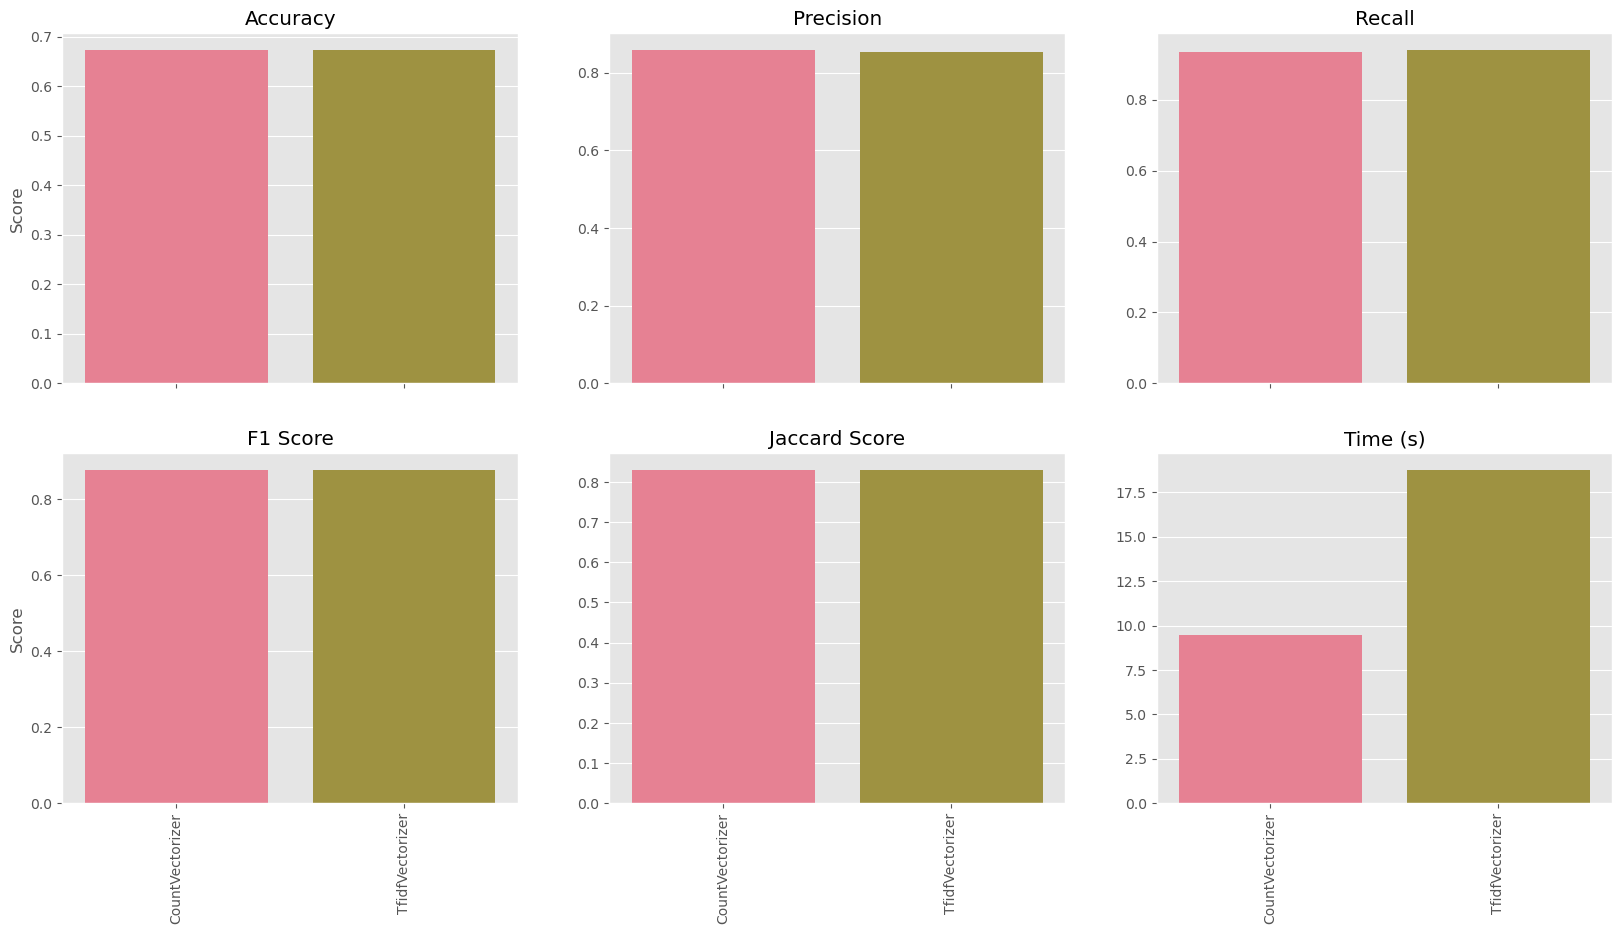

In [52]:
# Call the plot_results function
plot_results(results_RFC)

CountVectorizer permet d'avoir des performances similaires avec un temps d'entraînement plus court que TfidfVectorizer.

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Word2Vec</font>

In [53]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix

In [54]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts_list,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)

In [55]:
# Train the Word2Vec model on your text data
w2v_model = Word2Vec(X_train, vector_size=1000, window=5, min_count=5, workers=4)

In [56]:
# Create a vocabulary of only the words in the text data that are in the word2vec model
vocab = set(w2v_model.wv.key_to_index.keys())

In [57]:
# Filter the text data to only include words in the vocabulary
X_train = [[word for word in sublist if word in vocab] for sublist in X_train]
X_test = [[word for word in sublist if word in vocab] for sublist in X_test]

In [58]:
# Remove any observations that have no words in the vocabulary
train_removed_indexes = []
test_removed_indexes = []
for i, sublist in enumerate(X_train):
    if not any(word in vocab for word in sublist):
        train_removed_indexes.append(i)
for i, sublist in enumerate(X_test):
    if not any(word in vocab for word in sublist):
        test_removed_indexes.append(i)

In [59]:
X_train = [x for i, x in enumerate(X_train) if i not in train_removed_indexes]
X_test = [x for i, x in enumerate(X_test) if i not in test_removed_indexes]
y_train = [x for i, x in enumerate(y_train) if i not in train_removed_indexes]
y_test = [x for i, x in enumerate(y_test) if i not in test_removed_indexes]

In [60]:
# Create embeddings for train and test data
X_train_embedded = [np.mean([w2v_model.wv[word] for word in sentence], axis=0) for sentence in X_train]
X_test_embedded = [np.mean([w2v_model.wv[word] for word in sentence], axis=0) for sentence in X_test]

In [61]:
clf = OneVsRestClassifier(LogisticRegression(random_state=42))

In [62]:
# Fit the classifier on the train data
clf.fit(X_train_embedded, y_train)

OneVsRestClassifier(estimator=LogisticRegression(random_state=42))

In [63]:
# Make predictions on the test data
y_pred = clf.predict(X_test_embedded)

In [64]:
# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
jaccard = jaccard_score(y_test, y_pred, average='samples')

# Print the results
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))
print("Jaccard Score: {:.2f}".format(jaccard))

Accuracy: 0.57
Precision: 0.84
Recall: 0.90
F1-Score: 0.87
Jaccard Score: 0.79


In [65]:
# CM = multilabel_confusion_matrix(y_test, y_pred)

In [66]:
# average_cm = np.mean(CM, axis=0)

In [153]:
# sns.heatmap(average_cm, annot=True, cmap='Blues', fmt='.2g')
# plt.show()

In [68]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier()]

In [69]:
def calculate_supervised_word2vec(X_train, X_test, y_train, y_test, classifiers):
    
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall',
                                       'F1 Score', 'Jaccard Score', 'Time (s)'])
    
    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for clf in classifiers:
        start_time = time.time()
        ovrc = OneVsRestClassifier(clf)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        end_time = time.time()
        
        accuracy = round(accuracy_score(y_test, y_pred_ovrc), 4)
        precision = round(precision_score(y_test, y_pred_ovrc, average='samples'), 4)
        recall = round(recall_score(y_test, y_pred_ovrc, average='samples'), 4)
        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        time_taken = round(end_time - start_time, 4)
        
        results_df = results_df.append({'Classifier': str(clf).split('(')[0], 
                                       'Accuracy': accuracy, 
                                       'Precision': precision, 
                                       'Recall': recall, 
                                       'F1 Score': f1, 
                                       'Jaccard Score': jaccard,
                                       'Time (s)': time_taken}, 
                                       ignore_index=True)
        
    return results_df

In [70]:
results_df_word2vec = calculate_supervised_word2vec(X_train_embedded,
                                                    X_test_embedded,
                                                    y_train,
                                                    y_test,
                                                    classifiers)

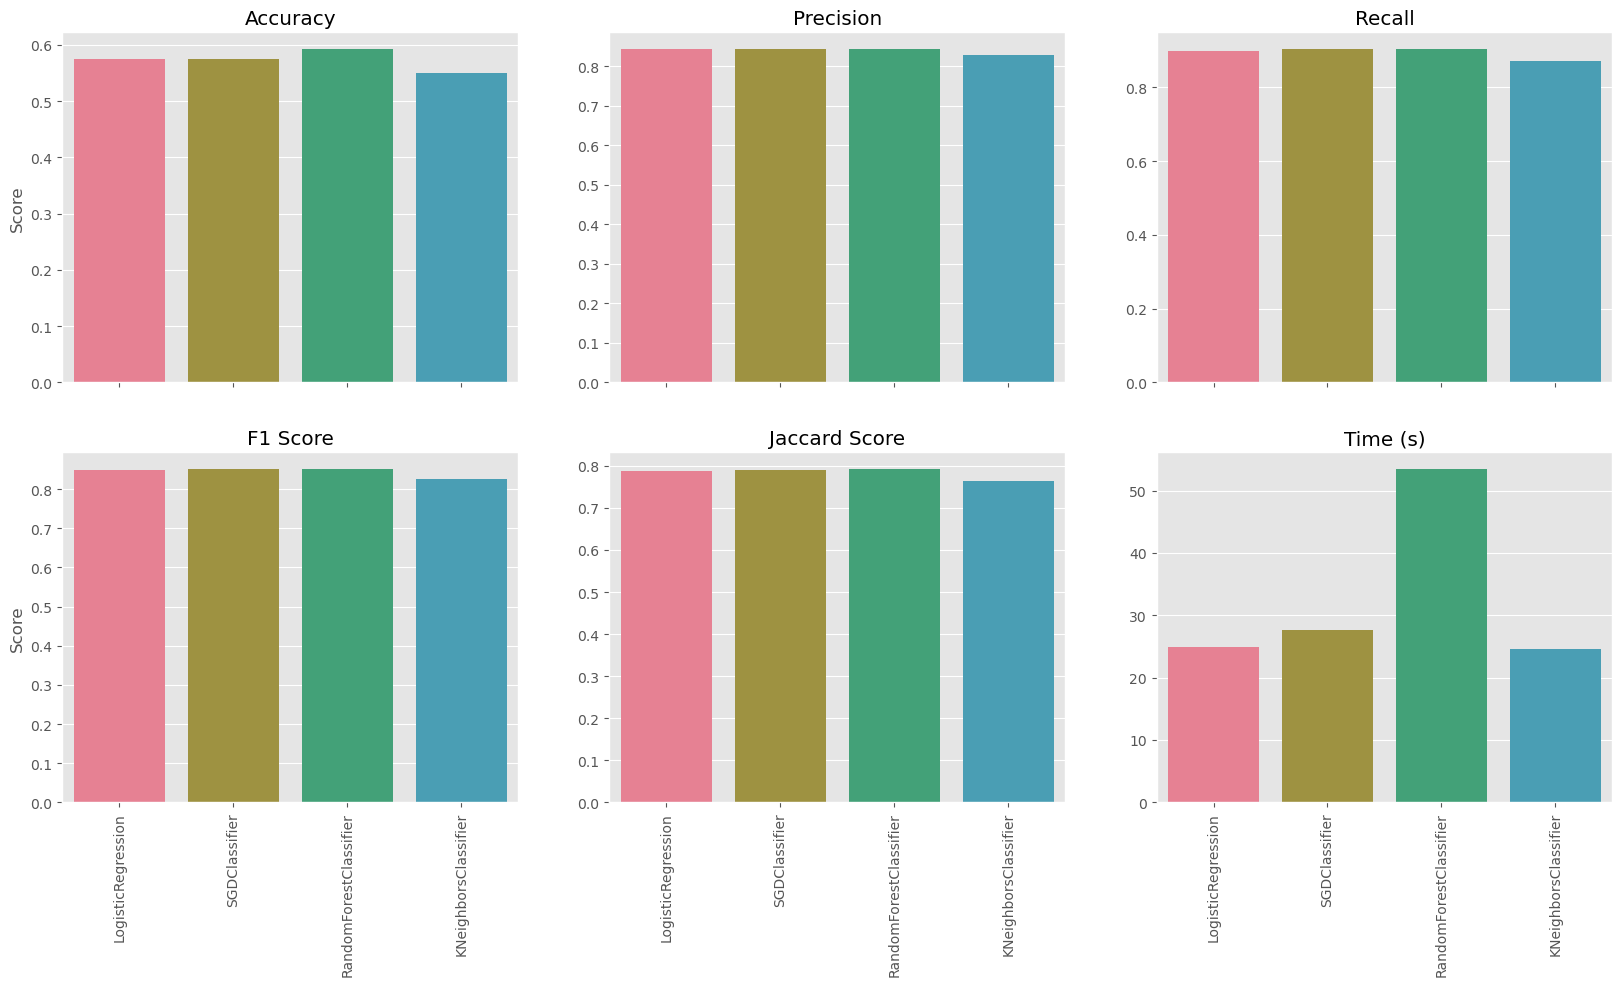

In [71]:
# Call the plot_results function
plot_results(results_df_word2vec)

## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : BERT</font>

In [72]:
import torch
import tensorflow_hub as hub
import tensorflow as tf
import transformers
import tokenization
from transformers import BertTokenizer, AutoModel, BertTokenizerFast
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [ ]:
from collections import Counter

vocabulary_tags = set([word for word, count in Counter([word for item in tags_list for word in item]).most_common() if count >= 20])

In [73]:
# pip install  torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 --user -f https://download.pytorch.org/whl/torch_stable.html

In [74]:
texts = data_sample['Texts'].copy()
tags = data_sample['Tags'].copy()

In [75]:
for i in range(len(texts)):
    texts[i] = " ".join(texts[i])
    tags[i] = " ".join(tags[i])

In [76]:
# mlb = MultiLabelBinarizer()
# tags_bin = mlb.fit_transform(tags)

In [77]:
mlb = MultiLabelBinarizer()
tags_bin = mlb.fit_transform(tags_list)

In [78]:
train_text, test_text, train_labels, test_labels = train_test_split(texts, 
                                                                    tags_bin, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

In [79]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [80]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [81]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [82]:
tokens_train = bert_encode(train_text.values, tokenizer, max_len=100)
tokens_test = bert_encode(test_text.values, tokenizer, max_len=100)

In [83]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    out = Dense(len(vocabulary_tags), activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model

In [84]:
model = build_model(bert_layer, max_len=100)

In [85]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

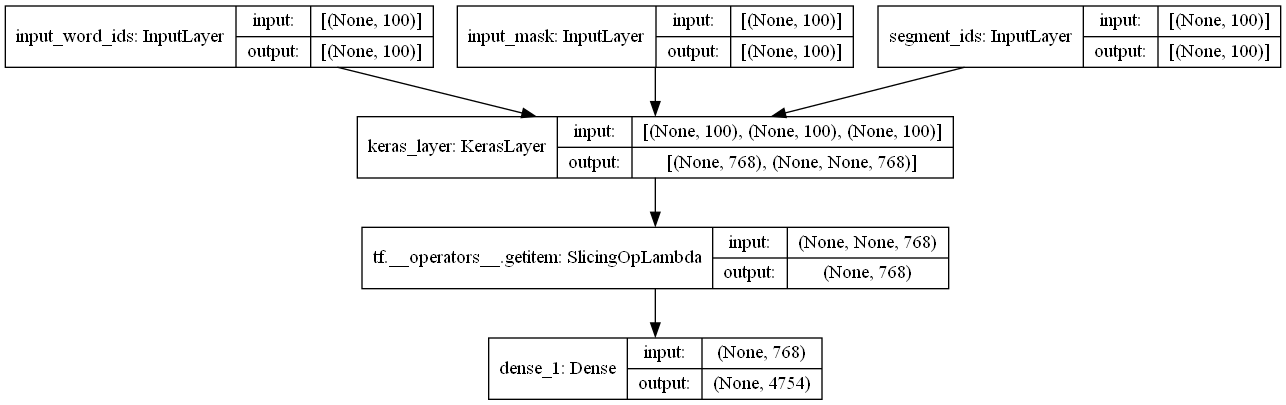

In [86]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [87]:
# use one-hot encoded labels for training
train_history = model.fit(
    tokens_train, train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
)

Epoch 1/5
100/100 [==============================] - 52s 411ms/step - loss: 0.6684 - binary_accuracy: 0.5962 - val_loss: 0.6301 - val_binary_accuracy: 0.6913
Epoch 2/5
100/100 [==============================] - 40s 403ms/step - loss: 0.6002 - binary_accuracy: 0.7596 - val_loss: 0.5734 - val_binary_accuracy: 0.8153
Epoch 3/5
100/100 [==============================] - 40s 404ms/step - loss: 0.5512 - binary_accuracy: 0.8540 - val_loss: 0.5297 - val_binary_accuracy: 0.8847
Epoch 4/5
100/100 [==============================] - 40s 398ms/step - loss: 0.5101 - binary_accuracy: 0.9116 - val_loss: 0.4907 - val_binary_accuracy: 0.9374
Epoch 5/5
100/100 [==============================] - 39s 394ms/step - loss: 0.4728 - binary_accuracy: 0.9542 - val_loss: 0.4551 - val_binary_accuracy: 0.9678


In [88]:
model.evaluate(tokens_test, test_labels)

32/32 [==============================] - 5s 125ms/step - loss: 0.4551 - binary_accuracy: 0.9678


[0.45507800579071045, 0.9677820205688477]

In [89]:
example = model.predict(bert_encode(["I don't know how to to set the best number of layers and nodes in a NeuralNetwork,\
                                     but I think the best is to check in StackOverflow if someone already asked the same \
                                     question. Or I can start with 3 layers and correct afterwards if I don't get good results."], 
                                    tokenizer, 
                                    max_len=100))

In [90]:
indices = np.argsort(example)[0][-5:]
example[0, indices] = 1
example[np.where(example != 1)] = 0
decoded = mlb.inverse_transform(example)
decoded

[('kerberos', 'pdfkit', 'tmx', 'urllib2', 'valgrind')]

In [159]:
flat_texts[20]

'path process linux environment path process way'

In [161]:
example = model.predict(bert_encode(flat_texts[20], 
                                    tokenizer, 
                                    max_len=100))

In [163]:
indices = np.argsort(example)[0][-5:]
example[0, indices] = 1
example[np.where(example != 1)] = 0
decoded = mlb.inverse_transform(example)
decoded[0]

('django-database', 'file-conversion', 'hql', 'jlist', 'pi')

In [165]:
text_stack_example = ["I am constructing a discrete choice experiment in Qualtrics. The only explanation I found for this was for Stata which I do not have (https://journals.sagepub.com/doi/10.1177/0894439319885317#fig2-0894439319885317). So I use R instead but have difficulties translating the Stata code into R code. Could anyone help me with this?Definition of parameters for HTML tables *Reference for HTML colors: https://www.w3schools.com/colors/colors_picker.asp local rulecolor #1524D9 // (= bright blue) color of the table's rules local cellcolor #BEDCFC // (= light blue) background color of the table's cells local firstheadcolstyle style='width:180px; border-bottom: 1px solid rulecolor';' local headcolstyle bgcolor='cellcolor''' style='width:270px; text-align: center; border-left: 4px solid rulecolor'; border-top: 4px solid rulecolor'; border-right: 4px solid rulecolor'; border-bottom: 1px solid rulecolor';'' local headrowstyle height= style text-align: left; border-bottom: 1px solid rulecolor' local rowstyle bgcolor=cellcolor'' style=text-align: center; border-left: 4px solid rulecolor'; border-right: 4px solid rulecolor'; border-bottom: 1px solid rulecolor'; local lastrowstyle bgcolor=cellcolor style=text-align: center; border-left: 4px solid rulecolor'; border-right: 4px solid rulecolor'; border-bottom: 4px solid `rulecolor';Initialize txt document texdoc init DCE_{lg}.txt, replace tex [[AdvancedFormat]]"]

In [166]:
example = model.predict(bert_encode(text_stack_example, 
                                    tokenizer, 
                                    max_len=100))

In [167]:
indices = np.argsort(example)[0][-5:]
example[0, indices] = 1
example[np.where(example != 1)] = 0
decoded = mlb.inverse_transform(example)
decoded[0]

('alphabet', 'dreamweaver', 'pdfkit', 'region', 'valgrind')

In [91]:
model.save(main_path+'saved_ressources/model.h5')

In [92]:
# code to load it into another program without having to re-train it
# from tensorflow import keras
# model = keras.models.load_model('/content/model.h5')

## <font color="#114b98" id="section_6">6. Approche supervisée avec Sentence Embedding : USE</font>

In [93]:
from rake_nltk import Rake
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [94]:
def extract_keywords(input_text):
    # Load the USE model
    model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    all_keywords = []
    # Encode all the sentences in the input text
    embeddings = model(input_text)
    # Compute the cosine similarity between all the sentences
    similarity_matrix = cosine_similarity(embeddings)
    # Iterate over the list of sentences
    for i in range(len(input_text)):
        # Find the most similar sentences
        most_similar = np.argsort(-similarity_matrix[i])[1:6]
        # Combine the most similar sentences with the current sentence
        text = ' '.join([input_text[j] for j in most_similar])
        # Extract the keywords from the combined text using RAKE
        keyword_extractor = Rake()
        keyword_extractor.extract_keywords_from_text(text)
        keywords = keyword_extractor.get_ranked_phrases()[:5]
        all_keywords.append(keywords)
    return all_keywords

In [95]:
data_use = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned_wo_tokenizer.csv', encoding='utf8')

In [96]:
data_use['Texts'][0:1].to_list()

['how get scheme interpreter working inside emacs going through sicp and like have interpreter analogous the interactive python interpreter play around while watching the lectures and reading the book furthermore like this interpreter run inside emacs can jump back and forth between files scheme code and the interactive interpreter and forth however fairly new emacs and have not yet been able get this work find one clear set instructions use getting work seems like should able set that run scheme will open interactive interpreter that least sounds like exactly what want but the moment this just returns searching for program such file directory scheme and haven been able figure out exactly what files need put where remedy this running gnu emacs mac apple darwin carbon version installed through the install dvd']

In [97]:
list_use = data_use['Texts'][0:2].to_list()

In [98]:
# Example usage
sentences = ["BERT is a powerful language model trained by Google.",
             "text classification with BERT",
             "BERT for Question Answering"]

In [99]:
# sentences = list_use

In [333]:
keywords = extract_keywords(sentences)
print(keywords[0])

['text classification', 'question answering', 'bert bert']


In [368]:
split_keywords = [word for keyword in keywords[0] for word in keyword.split()]
keywords_set = set(split_keywords)
print(keywords_set)

{'text', 'answering', 'question', 'bert', 'classification'}
